# ⚽ Soccer ML Lab Training Notebook

Use this notebook to load match-level soccer data, build classification models that predict whether the home team wins, and persist the trained artifacts. Update file paths and column names to align with your dataset before running the workflow.

## 1. Set Up Environment

Install the project dependencies (pandas, NumPy, scikit-learn, matplotlib, seaborn, joblib) in your active environment if they are not already present. Then import the libraries and configure the file paths that will be used throughout the analysis.

In [19]:
# Uncomment the next line if you need to install dependencies inside the notebook runtime.
# %pip install pandas numpy scikit-learn matplotlib seaborn joblib

from pathlib import Path
from datetime import datetime
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
 )
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

sns.set_theme(context="notebook", style="whitegrid")
RANDOM_STATE = 42

PROJECT_ROOT = Path(".").resolve()
DATA_DIR = PROJECT_ROOT / "data"
MATCHES_PATH = DATA_DIR / "dataset - 2020-09-24.csv"  # Update if your dataset lives elsewhere

print(f"Project root: {PROJECT_ROOT}")
print(f"Expecting match dataset at: {MATCHES_PATH}")
if not MATCHES_PATH.exists():
    raise FileNotFoundError(
        f"Dataset was not found at {MATCHES_PATH}. Update MATCHES_PATH to your file location before continuing."
    )

Project root: C:\Users\Andre\soccer-ml-lab
Expecting match dataset at: C:\Users\Andre\soccer-ml-lab\data\dataset - 2020-09-24.csv


## 2. Load Soccer Dataset

Read the raw match-level data into a DataFrame. The helper below supports CSV and Parquet inputs; adjust the file path or reader arguments if your dataset differs.

In [20]:
def load_matches_dataset(path: Path) -> pd.DataFrame:
    if path.suffix.lower() == ".csv":
        df = pd.read_csv(path)
    elif path.suffix.lower() in {".parquet", ".pq"}:
        df = pd.read_parquet(path)
    else:
        raise ValueError(f"Unsupported file type: {path.suffix}. Provide a CSV or Parquet file.")
    if df.empty:
        raise ValueError("The loaded dataset is empty. Verify the source file contains rows.")
    return df

matches_df = load_matches_dataset(MATCHES_PATH)
print(f"Loaded {len(matches_df):,} rows and {len(matches_df.columns)} columns from the match dataset.")

required_target_inputs = {"Wins", "Losses"}
if not required_target_inputs.issubset(matches_df.columns):
    missing = required_target_inputs - set(matches_df.columns)
    raise KeyError(
        "Cannot derive classification target because the dataset is missing the following columns: "
        + ", ".join(sorted(missing))
    )

matches_df = matches_df.dropna(subset=list(required_target_inputs))
matches_df["win_diff"] = matches_df["Wins"] - matches_df["Losses"]
matches_df["has_positive_record"] = (matches_df["win_diff"] >= 0).astype(int)

TARGET_COL = "has_positive_record"
print(
    "Target distribution (positive record vs not):",
    matches_df[TARGET_COL].value_counts().to_dict(),
)

matches_df.head()

Loaded 571 rows and 59 columns from the match dataset.
Target distribution (positive record vs not): {1: 326, 0: 245}


,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides,win_diff,has_positive_record
0,Bernd Leno,1.0,Arsenal,Goalkeeper,Germany,28.0,64,28,16,0,...,17.0,28.0,375.0,489.0,2,0,0,NaN,12,1
1,Matt Macey,33.0,Arsenal,Goalkeeper,England,26.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0,0,NaN,0,1
2,Rúnar Alex Rúnarsson,13.0,Arsenal,Goalkeeper,Iceland,25.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0,0,NaN,0,1
3,Héctor Bellerín,2.0,Arsenal,Defender,Spain,25.0,160,90,37,7,...,NaN,NaN,NaN,NaN,23,0,125,8.0,53,1
4,Kieran Tierney,3.0,Arsenal,Defender,Scotland,23.0,16,7,5,1,...,NaN,NaN,NaN,NaN,2,0,9,0.0,2,1


## 3. Inspect Dataset Structure

Review schema, missing values, class balance, and summary statistics to understand data quality before modeling.

In [21]:
matches_df.info()

missing_counts = matches_df.isna().sum().sort_values(ascending=False)
print("\nMissing values (top 10 columns):")
print(missing_counts.head(10))

class_distribution = matches_df[TARGET_COL].value_counts().sort_index()
print("\nClass distribution (target):")
print(class_distribution)
print("\nClass distribution (%)")
print((class_distribution / class_distribution.sum() * 100).round(2))

summary_stats = matches_df.describe(include="all")
summary_stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 61 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    571 non-null    object 
 1   Jersey Number           563 non-null    float64
 2   Club                    571 non-null    object 
 3   Position                571 non-null    object 
 4   Nationality             570 non-null    object 
 5   Age                     570 non-null    float64
 6   Appearances             571 non-null    int64  
 7   Wins                    571 non-null    int64  
 8   Losses                  571 non-null    int64  
 9   Goals                   571 non-null    int64  
 10  Goals per match         309 non-null    float64
 11  Headed goals            502 non-null    float64
 12  Goals with right foot   502 non-null    float64
 13  Goals with left foot    502 non-null    float64
 14  Penalties scored        309 non-null    fl

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides,win_diff,has_positive_record
count,571,563.000000,571,571,570,570.000000,571.000000,571.000000,571.000000,571.000000,...,69.000000,69.000000,69.000000,69.000000,571.000000,571.000000,571.000000,502.000000,571.000000,571.000000
unique,571,NaN,20,4,57,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Bernd Leno,NaN,Liverpool,Midfielder,England,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,34,198,221,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,19.534636,NaN,NaN,NaN,25.789474,68.823117,28.957968,23.896673,7.327496,...,20.782609,25.565217,210.000000,414.144928,7.917688,0.301226,53.033275,11.063745,5.061296,0.570928
std,NaN,14.273515,NaN,NaN,NaN,4.377354,81.797516,38.969376,28.488376,16.810490,...,43.058397,47.333758,334.822473,641.246265,11.556811,0.698607,75.605560,26.570058,26.564547,0.495378
min,NaN,1.000000,NaN,NaN,NaN,17.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-47.000000,0.000000
25%,NaN,8.000000,NaN,NaN,NaN,22.000000,3.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-6.000000,0.000000
50%,NaN,18.000000,NaN,NaN,NaN,26.000000,36.000000,12.000000,14.000000,1.000000,...,3.000000,4.000000,39.000000,53.000000,3.000000,0.000000,22.000000,2.000000,0.000000,1.000000
75%,NaN,27.000000,NaN,NaN,NaN,29.000000,108.000000,41.000000,36.000000,6.000000,...,17.000000,28.000000,300.000000,527.000000,11.000000,0.000000,74.000000,8.750000,5.500000,1.000000


## 4. Clean and Encode Features

Remove identifiers and columns that leak the engineered target (such as Wins, Losses, and win_diff) before modeling. Then create domain-aware features where possible and assemble preprocessing pipelines for numeric and categorical inputs.

In [22]:
DROP_COLUMNS = [
    "Wins",
    "Losses",
    "win_diff",
    # Add other leakage-prone or identifier columns below, e.g., "match_id", "season".
]

feature_df = matches_df.drop(columns=[TARGET_COL], errors="ignore")

if DROP_COLUMNS:
    available_drop = [col for col in DROP_COLUMNS if col in feature_df.columns]
    if available_drop:
        feature_df = feature_df.drop(columns=available_drop, errors="ignore")
        print(f"Removed {len(available_drop)} leakage/identifier columns: {available_drop}")

engineered_df = feature_df.copy()
if {"home_shots", "away_shots"}.issubset(matches_df.columns):
    engineered_df["shot_diff"] = matches_df["home_shots"] - matches_df["away_shots"]
if {"home_xg", "away_xg"}.issubset(matches_df.columns):
    engineered_df["xg_diff"] = matches_df["home_xg"] - matches_df["away_xg"]
if {"home_possession", "away_possession"}.issubset(matches_df.columns):
    engineered_df["possession_diff"] = matches_df["home_possession"] - matches_df["away_possession"]

feature_df = engineered_df
FEATURE_COLUMNS = feature_df.columns.tolist()
print(f"Total feature columns after engineering: {len(FEATURE_COLUMNS)}")

numeric_features = feature_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [col for col in FEATURE_COLUMNS if col not in numeric_features]
print(f"Numeric features: {len(numeric_features)} | Categorical features: {len(categorical_features)}")

transformers = []
if numeric_features:
    numeric_processor = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )
    transformers.append(("numeric", numeric_processor, numeric_features))

if categorical_features:
    categorical_processor = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            (
                "encoder",
                OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            ),
        ]
    )
    transformers.append(("categorical", categorical_processor, categorical_features))

if not transformers:
    raise ValueError("No features available for modeling. Ensure FEATURE_COLUMNS is not empty.")

preprocessor = ColumnTransformer(transformers=transformers)
feature_df.head()

Removed 3 leakage/identifier columns: ['Wins', 'Losses', 'win_diff']
Total feature columns after engineering: 57
Numeric features: 50 | Categorical features: 7


,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Goals,Goals per match,Headed goals,...,Punches,High Claims,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides
0,Bernd Leno,1.0,Arsenal,Goalkeeper,Germany,28.0,64,0,NaN,NaN,...,34.0,26.0,17.0,28.0,375.0,489.0,2,0,0,NaN
1,Matt Macey,33.0,Arsenal,Goalkeeper,England,26.0,0,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN
2,Rúnar Alex Rúnarsson,13.0,Arsenal,Goalkeeper,Iceland,25.0,0,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN
3,Héctor Bellerín,2.0,Arsenal,Defender,Spain,25.0,160,7,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,23,0,125,8.0
4,Kieran Tierney,3.0,Arsenal,Defender,Scotland,23.0,16,1,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,0,9,0.0


## 5. Split Data for Training

Create stratified train/validation/test splits so that class proportions remain stable across subsets.

In [23]:
X = feature_df.copy()
y = matches_df[TARGET_COL].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y,
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=RANDOM_STATE,
    stratify=y_temp,
)

print(
    "Split sizes (rows):",
    {
        "train": len(X_train),
        "valid": len(X_valid),
        "test": len(X_test),
    },
)


Split sizes (rows): {'train': 399, 'valid': 86, 'test': 86}


## 6. Define and Train Baseline Model

Train an initial classifier using the preprocessing pipeline plus a simple algorithm (Logistic Regression) to establish a baseline.

In [24]:
baseline_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            LogisticRegression(
                max_iter=1000,
                random_state=RANDOM_STATE,
                class_weight="balanced",
            ),
        ),
    ]
)

baseline_pipeline.fit(X_train, y_train)
print("Baseline model trained.")

Baseline model trained.


## 7. Evaluate Model Performance

Generate validation predictions, compute a suite of classification metrics, and visualise the confusion matrix to identify common error modes.

In [25]:
y_valid_pred = baseline_pipeline.predict(X_valid)
y_valid_proba = baseline_pipeline.predict_proba(X_valid)[:, 1]

baseline_metrics = {
    "accuracy": accuracy_score(y_valid, y_valid_pred),
    "precision": precision_score(y_valid, y_valid_pred, zero_division=0),
    "recall": recall_score(y_valid, y_valid_pred, zero_division=0),
    "f1": f1_score(y_valid, y_valid_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_valid, y_valid_proba),
}

print("Baseline validation metrics:")
for name, value in baseline_metrics.items():
    print(f"  {name:>9}: {value:.3f}")

print("\nClassification report (validation):")
print(classification_report(y_valid, y_valid_pred, zero_division=0))

Baseline validation metrics:
   accuracy: 0.791
  precision: 0.804
     recall: 0.837
         f1: 0.820
    roc_auc: 0.860

Classification report (validation):
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        37
           1       0.80      0.84      0.82        49

    accuracy                           0.79        86
   macro avg       0.79      0.78      0.78        86
weighted avg       0.79      0.79      0.79        86



## 8. Tune Hyperparameters

Leverage cross-validated RandomizedSearchCV to explore a richer model family (Random Forest) and identify improved hyperparameters.

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV F1: 0.797
Best parameters:
  model__n_estimators: 600
  model__min_samples_split: 2
  model__min_samples_leaf: 1
  model__max_features: 0.75
  model__max_depth: None

Random Forest validation metrics:
   accuracy: 0.837
  precision: 0.843
     recall: 0.878
         f1: 0.860
    roc_auc: 0.866


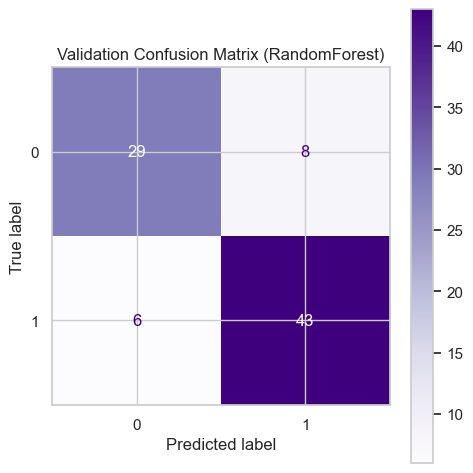

In [26]:
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            RandomForestClassifier(
                random_state=RANDOM_STATE,
                n_jobs=-1,
                class_weight="balanced",
            ),
        ),
    ]
)

param_distributions = {
    "model__n_estimators": [200, 300, 400, 500, 600],
    "model__max_depth": [None, 10, 20, 30, 40],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.5, 0.75],
}

search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="f1",
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE,
    verbose=1,
 )

search.fit(X_train, y_train)
print(f"Best CV F1: {search.best_score_:.3f}")
print("Best parameters:")
for param, value in search.best_params_.items():
    print(f"  {param}: {value}")

best_model = search.best_estimator_
y_valid_pred_rf = best_model.predict(X_valid)
y_valid_proba_rf = best_model.predict_proba(X_valid)[:, 1]

rf_metrics = {
    "accuracy": accuracy_score(y_valid, y_valid_pred_rf),
    "precision": precision_score(y_valid, y_valid_pred_rf, zero_division=0),
    "recall": recall_score(y_valid, y_valid_pred_rf, zero_division=0),
    "f1": f1_score(y_valid, y_valid_pred_rf, zero_division=0),
    "roc_auc": roc_auc_score(y_valid, y_valid_proba_rf),
}

print("\nRandom Forest validation metrics:")
for name, value in rf_metrics.items():
    print(f"  {name:>9}: {value:.3f}")

comparison_df = pd.DataFrame(
    [baseline_metrics, rf_metrics],
    index=["Baseline_LogReg", "Tuned_RandomForest"],
)
comparison_df

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_valid, y_valid_pred_rf, ax=ax, cmap="Purples")
ax.set_title("Validation Confusion Matrix (RandomForest)")
plt.tight_layout()
plt.show()

## 9. Persist Trained Model

Retrain the tuned estimator on the combined train+validation data, evaluate on the holdout test split, and persist both the model and metadata for downstream use.

In [27]:
X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

best_model.fit(X_train_full, y_train_full)
print("Tuned model retrained on train+validation data.")

y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

test_metrics = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred, zero_division=0),
    "recall": recall_score(y_test, y_test_pred, zero_division=0),
    "f1": f1_score(y_test, y_test_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_test_proba),
}

print("Test metrics:")
for name, value in test_metrics.items():
    print(f"  {name:>9}: {value:.3f}")

MODEL_DIR = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / "match_winner_model.joblib"
METADATA_PATH = MODEL_DIR / "match_winner_metadata.json"

joblib.dump(best_model, MODEL_PATH)
print(f"Saved trained model to {MODEL_PATH.relative_to(PROJECT_ROOT)}")

metadata = {
    "generated_at": datetime.utcnow().isoformat() + "Z",
    "data_source": str(MATCHES_PATH.relative_to(PROJECT_ROOT)),
    "target_column": TARGET_COL,
    "feature_columns": FEATURE_COLUMNS,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "dropped_columns": [col for col in DROP_COLUMNS if col in matches_df.columns],
    "baseline_metrics_valid": baseline_metrics,
    "tuned_metrics_valid": rf_metrics,
    "best_cv_f1_mean": float(search.best_score_),
    "test_metrics": test_metrics,
    "train_row_count": int(len(X_train_full)),
    "validation_row_count": int(len(X_valid)),
    "test_row_count": int(len(X_test)),
    "random_state": RANDOM_STATE,
    "best_params": search.best_params_,
    "scikit_learn_version": sklearn.__version__,
    "pandas_version": pd.__version__,
}

with METADATA_PATH.open("w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)
print(f"Saved metadata to {METADATA_PATH.relative_to(PROJECT_ROOT)}")

Tuned model retrained on train+validation data.
Test metrics:
   accuracy: 0.849
  precision: 0.846
     recall: 0.898
         f1: 0.871
    roc_auc: 0.913
Saved trained model to models\match_winner_model.joblib
Saved metadata to models\match_winner_metadata.json


C:\Users\Andre\AppData\Local\Temp\ipykernel_2124\2030121533.py:31: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat() + "Z",


## 10. Insights and Performance Summary

Use the captured metrics to document how the models behaved and what stood out in this training run.

In [28]:
insight_lines = []

class_counts = matches_df[TARGET_COL].value_counts().sort_index()
total_matches = int(class_counts.sum())
minority_class = int(class_counts.idxmin()) if len(class_counts) > 1 else int(class_counts.index[0])
minority_share = float((class_counts.min() / total_matches) * 100)
insight_lines.append(
    f"Dataset contains {total_matches} matches; minority class ({minority_class}) represents {minority_share:.1f}% of samples."
)

if "baseline_metrics" in globals() and "rf_metrics" in globals():
    baseline_f1 = baseline_metrics.get("f1")
    rf_f1 = rf_metrics.get("f1")
    if baseline_f1 is not None and rf_f1 is not None:
        uplift = rf_f1 - baseline_f1
        insight_lines.append(
            f"RandomForest validation F1 = {rf_f1:.3f} vs baseline {baseline_f1:.3f} (Δ {uplift:+.3f})."
        )
    baseline_acc = baseline_metrics.get("accuracy")
    rf_acc = rf_metrics.get("accuracy")
    if baseline_acc is not None and rf_acc is not None:
        uplift_acc = rf_acc - baseline_acc
        insight_lines.append(
            f"Validation accuracy improved from {baseline_acc:.3f} to {rf_acc:.3f} (Δ {uplift_acc:+.3f})."
        )

if "test_metrics" in globals():
    test_snapshot = ", ".join(
        f"{name}={value:.3f}" for name, value in test_metrics.items()
    )
    insight_lines.append(f"Holdout test metrics: {test_snapshot}.")

if "search" in globals():
    insight_lines.append(
        f"Best CV F1 during tuning: {search.best_score_:.3f} with parameters {search.best_params_}."
    )

print("Key takeaways:")
for idx, line in enumerate(insight_lines, start=1):
    print(f"  {idx}. {line}")

Key takeaways:
  1. Dataset contains 571 matches; minority class (0) represents 42.9% of samples.
  2. RandomForest validation F1 = 0.860 vs baseline 0.820 (Δ +0.040).
  3. Validation accuracy improved from 0.791 to 0.837 (Δ +0.047).
  4. Holdout test metrics: accuracy=0.849, precision=0.846, recall=0.898, f1=0.871, roc_auc=0.913.
  5. Best CV F1 during tuning: 0.797 with parameters {'model__n_estimators': 600, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 0.75, 'model__max_depth': None}.
